In [ ]:
# Cell 1: Imports & Load
import pandas as pd
import numpy as np

# Path to your CSV
FILE_PATH = "breast-cancer.csv"  # change if needed

# Load
df = pd.read_csv(FILE_PATH)

print("Shape (raw):", df.shape)
df.head()


Shape (raw): (286, 11)


,Unnamed: 0,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [ ]:
# Cell 2: Drop obvious index/empty columns

df = df.copy()

dropped_cols = []

# Drop typical auto-index columns if present
for c in ["Unnamed: 0", "index", "Id", "ID"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)
        dropped_cols.append(c)

# Drop columns that are entirely NA
empty_cols = [c for c in df.columns if df[c].isna().all()]
if empty_cols:
    df.drop(columns=empty_cols, inplace=True)
    dropped_cols.extend(empty_cols)

print("Dropped columns:", dropped_cols)
print("Shape (after drop):", df.shape)
df.head()


Dropped columns: ['Unnamed: 0']
Shape (after drop): (286, 10)


,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [ ]:
# Cell 3: Normalize text & mark missing tokens

# Standardize placeholders to NA for object columns
missing_tokens = {"?": pd.NA, "na": pd.NA, "n/a": pd.NA, "none": pd.NA, "": pd.NA}

obj_cols = df.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    # ensure strings, strip whitespace, squash internal spaces
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .replace(missing_tokens)
    )

print("Object columns normalized:", obj_cols)
df.head()


Object columns normalized: ['Class', 'Age', 'Menopause', 'Tumor-size', 'Inv-nodes', 'Node-caps', 'Breast', 'Breast-quad', 'Irradiat']


,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [ ]:
# Cell 4: Remove duplicate rows

dup_count = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)

print(f"Removed {dup_count} duplicate rows.")
print("Shape (after dedupe):", df.shape)


Removed 14 duplicate rows.
Shape (after dedupe): (272, 10)


In [ ]:
# Cell 5: Missing values report (before impute)

missing_before = df.isna().sum().sort_values(ascending=False)
missing_rate = (df.isna().mean()*100).sort_values(ascending=False)

report_before = pd.DataFrame({
    "missing_count": missing_before,
    "missing_pct": missing_rate.round(2)
})
report_before


,missing_count,missing_pct
Node-caps,8,2.94
Breast-quad,1,0.37
Age,0,0.00
Class,0,0.00
Tumor-size,0,0.00
Menopause,0,0.00
Inv-nodes,0,0.00
Deg-malig,0,0.00
Breast,0,0.00
Irradiat,0,0.00


In [ ]:
# Cell 6: Simple imputations

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

imputations = []

# Numeric: median
for c in num_cols:
    n_miss = df[c].isna().sum()
    if n_miss > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        imputations.append((c, "numeric", n_miss, f"median={med}"))

# Categorical: mode (fallback to 'Unknown' if no mode)
for c in cat_cols:
    n_miss = df[c].isna().sum()
    if n_miss > 0:
        mode_vals = df[c].mode(dropna=True)
        fill_val = mode_vals.iloc[0] if len(mode_vals) else "Unknown"
        df[c] = df[c].fillna(fill_val)
        imputations.append((c, "categorical", n_miss, f"mode='{fill_val}'"))

print("Imputations performed:")
for item in imputations:
    print("  -", item)

# Verify missing after
missing_after = df.isna().sum().sort_values(ascending=False)
pd.DataFrame({
    "missing_before": missing_before,
    "missing_after": missing_after
}).fillna(0).astype(int)


Imputations performed:
  - ('Node-caps', 'categorical', np.int64(8), "mode='no'")
  - ('Breast-quad', 'categorical', np.int64(1), "mode='left_low'")


,missing_before,missing_after
Age,0,0
Breast,0,0
Breast-quad,1,0
Class,0,0
Deg-malig,0,0
Inv-nodes,0,0
Irradiat,0,0
Menopause,0,0
Node-caps,8,0
Tumor-size,0,0


In [ ]:
# Cell 8: Final info & save cleaned data

print("Final shape:", df.shape)
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

CLEAN_PATH = "breast_cancer_clean.csv"
df.to_csv(CLEAN_PATH, index=False)
print(f"Saved cleaned dataset to: {CLEAN_PATH}")

df.head(10)


Final shape: (272, 10)
Numeric columns: ['Deg-malig']
Categorical columns: ['Class', 'Age', 'Menopause', 'Tumor-size', 'Inv-nodes', 'Node-caps', 'Breast', 'Breast-quad', 'Irradiat']
Saved cleaned dataset to: breast_cancer_clean.csv


,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
5,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no
6,no-recurrence-events,50-59,premeno,25-29,0-2,no,2,left,left_low,no
7,no-recurrence-events,60-69,ge40,20-24,0-2,no,1,left,left_low,no
8,no-recurrence-events,40-49,premeno,50-54,0-2,no,2,left,left_low,no
9,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,left_up,no


#  Eda

In [ ]:
# Cell 9: Setup for EDA

import numpy as np
import matplotlib.pyplot as plt

# Map target to binary for convenience (1=recurrence, 0=no-recurrence)
y_map = {"recurrence-events": 1, "no-recurrence-events": 0}
y = df["Class"].map(y_map)

print("Data shape:", df.shape)
print("Target distribution (0=no-recurrence, 1=recurrence):")
print(y.value_counts().sort_index())
df.head()


Data shape: (272, 10)
Target distribution (0=no-recurrence, 1=recurrence):
Class
0    191
1     81
Name: count, dtype: int64


,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


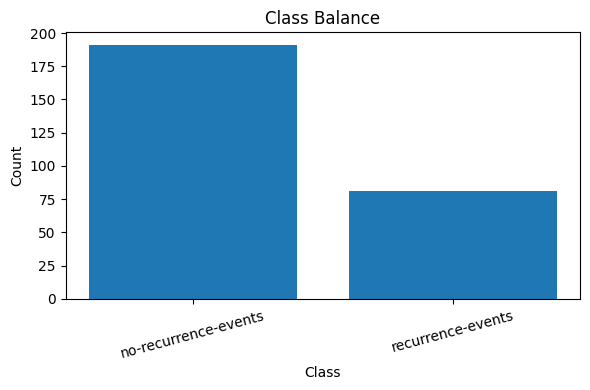

In [ ]:
# Cell 10: Class balance plot

counts = y.value_counts().sort_index()  # index 0,1
labels = ["no-recurrence-events", "recurrence-events"]

plt.figure(figsize=(6,4))
plt.bar(labels, [counts.get(0, 0), counts.get(1, 0)])
plt.title("Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


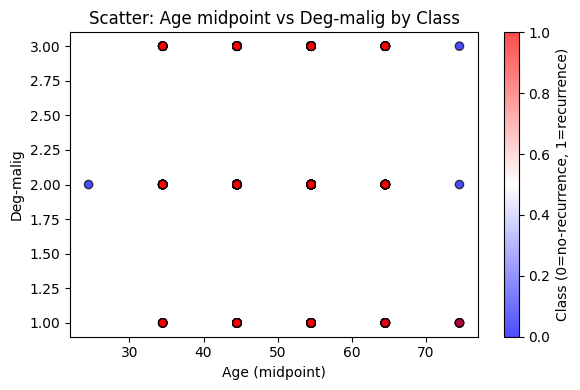

In [ ]:
# Extra EDA: Scatter of Age midpoint vs Deg-malig, colored by Class
import pandas as pd
import matplotlib.pyplot as plt

# Convert Age bins (e.g., "30-39") into numeric midpoints
def midpoint(age_bin):
    try:
        low, high = age_bin.split("-")
        return (int(low) + int(high)) / 2
    except:
        return None

df["Age_mid"] = df["Age"].apply(midpoint)

# Map target to 0/1
y = df["Class"].map({"recurrence-events": 1, "no-recurrence-events": 0})

plt.figure(figsize=(6,4))
plt.scatter(df["Age_mid"], df["Deg-malig"], c=y, cmap="bwr", alpha=0.7, edgecolor="k")
plt.title("Scatter: Age midpoint vs Deg-malig by Class")
plt.xlabel("Age (midpoint)")
plt.ylabel("Deg-malig")
plt.colorbar(label="Class (0=no-recurrence, 1=recurrence)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3652034142.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(col).apply(lambda g: y.loc[g.index].mean()*100).reindex(order)


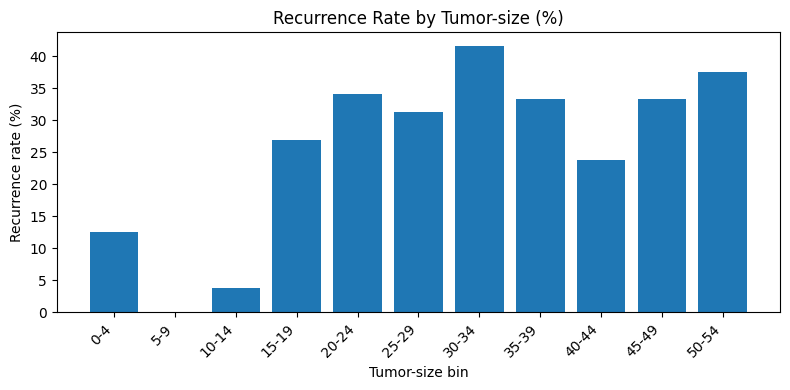

In [ ]:
# Cell 13: Recurrence rate by Tumor-size (%)

import numpy as np
import pandas as pd
col = "Tumor-size"

if col in df.columns:
    # Order bins numerically by lower bound (e.g., '0-4','5-9',...)
    def lower_bound(s):
        try:
            return int(str(s).split("-")[0])
        except Exception:
            return np.inf

    order = sorted(df[col].dropna().unique(), key=lower_bound)
    # % recurrence within each bin
    grouped = df.groupby(col).apply(lambda g: y.loc[g.index].mean()*100).reindex(order)

    plt.figure(figsize=(8,4))
    plt.bar(grouped.index.astype(str), grouped.values)
    plt.title("Recurrence Rate by Tumor-size (%)")
    plt.xlabel("Tumor-size bin")
    plt.ylabel("Recurrence rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{col}' not found.")


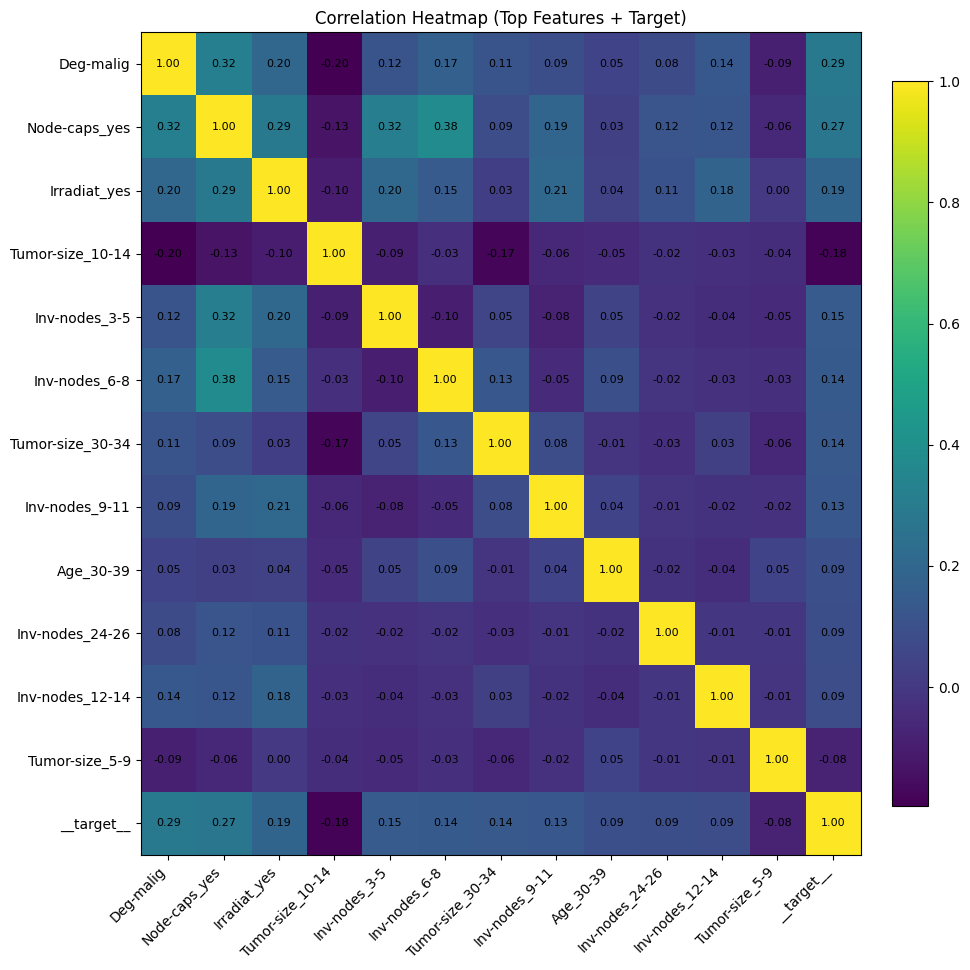

In [ ]:
# Heatmap: Correlation (Top Features + Target) with numeric labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Map target to 0/1
y = df["Class"].map({"recurrence-events": 1, "no-recurrence-events": 0})

# One-hot encode features
X_enc = pd.get_dummies(df.drop(columns=["Class"]), drop_first=True)

# Build correlation matrix including target
corr_df = X_enc.copy()
corr_df["__target__"] = y

# Pick top-k features most correlated with target
target_corr = corr_df.corr(numeric_only=True)["__target__"].drop("__target__", errors="ignore")
topk = min(12, len(target_corr))
top_feats = target_corr.abs().sort_values(ascending=False).head(topk).index.tolist()

cols_for_heat = top_feats + ["__target__"]
C = corr_df[cols_for_heat].corr(numeric_only=True)

# Plot heatmap with numeric labels
plt.figure(figsize=(max(8, 0.6*len(cols_for_heat)+2), max(6, 0.6*len(cols_for_heat)+2)))
im = plt.imshow(C.values, aspect="auto")
plt.title("Correlation Heatmap (Top Features + Target)")
plt.xticks(range(len(cols_for_heat)), cols_for_heat, rotation=45, ha="right")
plt.yticks(range(len(cols_for_heat)), cols_for_heat)
plt.colorbar(im, fraction=0.046, pad=0.04)

vals = np.round(C.values, 2)
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        plt.text(j, i, f"{vals[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 14: Train/Test split (stratified)

from sklearn.model_selection import train_test_split

TARGET_COL = "Class"
y_map = {"recurrence-events": 1, "no-recurrence-events": 0}
y = df[TARGET_COL].map(y_map)
X = df.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape,  y_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True).round(3))
print("Test class balance:\n",  y_test.value_counts(normalize=True).round(3))


Train shapes: (217, 10) (217,)
Test shapes:  (55, 10) (55,)
Train class balance:
 Class
0    0.7
1    0.3
Name: proportion, dtype: float64
Test class balance:
 Class
0    0.709
1    0.291
Name: proportion, dtype: float64


In [ ]:
# Cell 15: Preprocessing (Imputer + StandardScaler for numeric, One-Hot for categorical)

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Handle sklearn version differences (sparse_output vs sparse)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop"
)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
preprocess


Numeric columns: ['Deg-malig', 'Age_mid']
Categorical columns: ['Age', 'Menopause', 'Tumor-size', 'Inv-nodes', 'Node-caps', 'Breast', 'Breast-quad', 'Irradiat']


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Deg-malig', 'Age_mid']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Age', 'Menopause', 'Tumor-size', 'Inv-nodes',
                                  'Node-caps', 'Breast', 'Breast-quad',
                                  'Irradiat'])])

Processed shapes (before SMOTE): (217, 40) (55, 40)
Resampled train shape: (304, 40)
Class distribution after SMOTE:
 Class
0    152
1    152
Name: count, dtype: int64


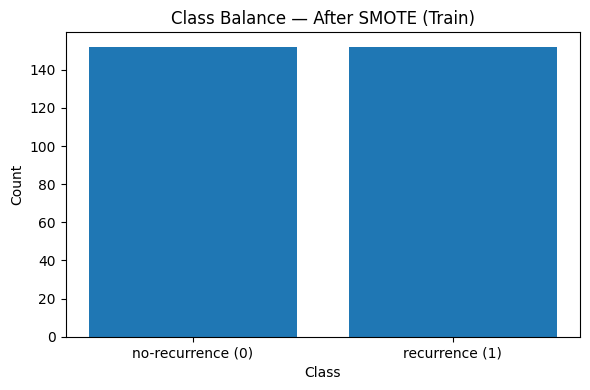

In [ ]:
# Cell 17: Apply SMOTE on preprocessed train only + plot after-SMOTE balance

# NOTE: We transform X_train with the preprocessing first (fit on train only),
# then run SMOTE on the numeric matrix. This avoids data leakage.

# Try importing imblearn; if missing, instruct to install.
try:
    from imblearn.over_sampling import SMOTE
except ImportError as e:
    raise ImportError(
        "imbalanced-learn is required. Install with:\n"
        "  pip install imbalanced-learn"
    ) from e

# Fit preprocess on train only
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Processed shapes (before SMOTE):", X_train_proc.shape, X_test_proc.shape)

# Apply SMOTE on TRAIN ONLY
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

print("Resampled train shape:", X_train_res.shape)
print("Class distribution after SMOTE:\n", y_train_res.value_counts())

# Plot AFTER-SMOTE class balance
import matplotlib.pyplot as plt

counts_after = y_train_res.value_counts().sort_index()
labels = ["no-recurrence (0)", "recurrence (1)"]

plt.figure(figsize=(6,4))
plt.bar(labels, [counts_after.get(0, 0), counts_after.get(1, 0)])
plt.title("Class Balance — After SMOTE (Train)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Model Implementation

SVC (RBF) — Test Metrics
  Accuracy : 0.727
  Precision: 0.524
  Recall   : 0.688
  F1-score : 0.595
  ROC-AUC  : 0.696


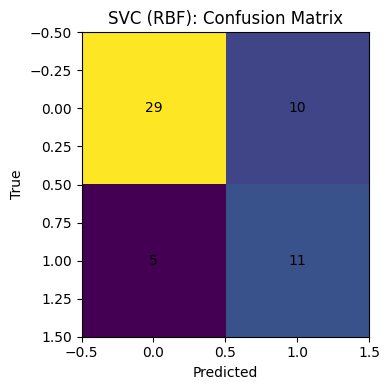

<Figure size 500x400 with 0 Axes>

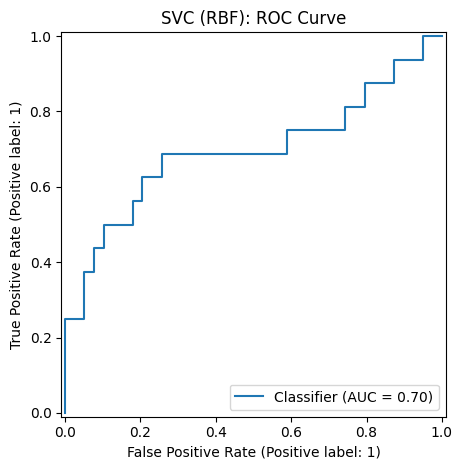

In [ ]:
# Cell 18: SVC (RBF) — train & evaluate

from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

# Train
svc_clf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
svc_clf.fit(X_train_res, y_train_res)

# Predict
y_pred = svc_clf.predict(X_test_proc)
y_proba = svc_clf.predict_proba(X_test_proc)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

print("SVC (RBF) — Test Metrics")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, aspect="auto")
plt.title("SVC (RBF): Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("SVC (RBF): ROC Curve")
plt.tight_layout()
plt.show()


Random Forest — Test Metrics
  Accuracy : 0.764
  Precision: 0.600
  Recall   : 0.562
  F1-score : 0.581
  ROC-AUC  : 0.679


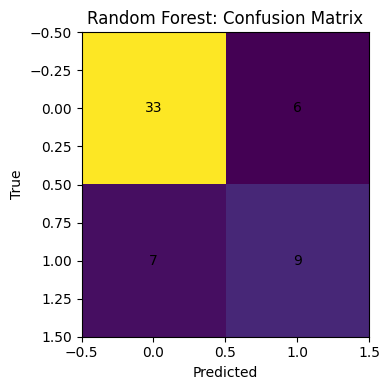

<Figure size 500x400 with 0 Axes>

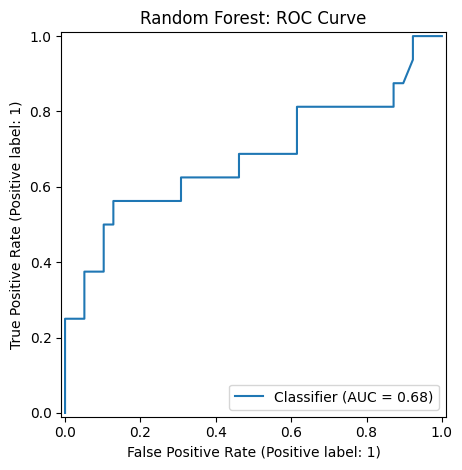

In [ ]:
# Cell 19: Random Forest — train & evaluate

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

# Train (no class_weight since SMOTE balanced)
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_res, y_train_res)

# Predict
y_pred = rf_clf.predict(X_test_proc)
y_proba = rf_clf.predict_proba(X_test_proc)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

print("Random Forest — Test Metrics")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, aspect="auto")
plt.title("Random Forest: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Random Forest: ROC Curve")
plt.tight_layout()
plt.show()


XGBoost — Test Metrics
  Accuracy : 0.727
  Precision: 0.533
  Recall   : 0.500
  F1-score : 0.516
  ROC-AUC  : 0.633


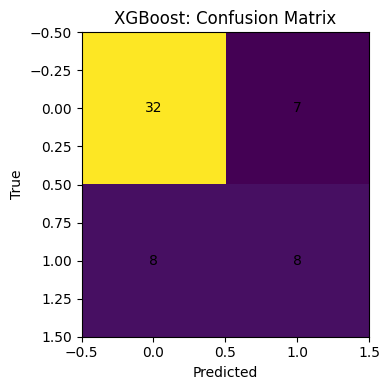

<Figure size 500x400 with 0 Axes>

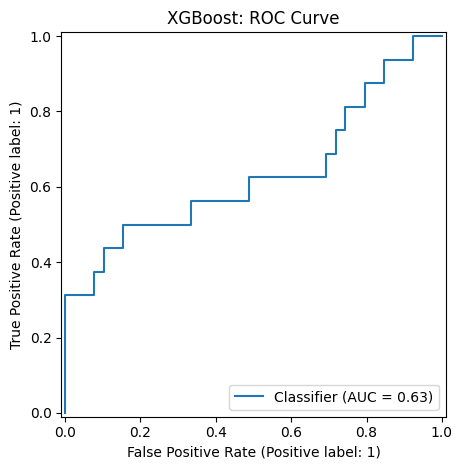

In [ ]:
# Cell 20: XGBoost — train & evaluate

# If you don't have xgboost installed:
#   pip install xgboost

try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost is required. Install with: pip install xgboost") from e

import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist"  # fast and robust
)

xgb_clf.fit(X_train_res, y_train_res)

# Predict
y_pred = xgb_clf.predict(X_test_proc)
y_proba = xgb_clf.predict_proba(X_test_proc)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

print("XGBoost — Test Metrics")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, aspect="auto")
plt.title("XGBoost: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("XGBoost: ROC Curve")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 21: Classification reports for SVC, Random Forest, and XGBoost
from sklearn.metrics import classification_report

print("="*60)
print("SVC (RBF) — Classification Report")
print("="*60)
y_pred_svc = svc_clf.predict(X_test_proc)
print(classification_report(
    y_test, y_pred_svc,
    target_names=["no-recurrence (0)", "recurrence (1)"],
    zero_division=0
))

print("="*60)
print("Random Forest — Classification Report")
print("="*60)
y_pred_rf = rf_clf.predict(X_test_proc)
print(classification_report(
    y_test, y_pred_rf,
    target_names=["no-recurrence (0)", "recurrence (1)"],
    zero_division=0
))

print("="*60)
print("XGBoost — Classification Report")
print("="*60)
y_pred_xgb = xgb_clf.predict(X_test_proc)
print(classification_report(
    y_test, y_pred_xgb,
    target_names=["no-recurrence (0)", "recurrence (1)"],
    zero_division=0
))


SVC (RBF) — Classification Report
                   precision    recall  f1-score   support

no-recurrence (0)       0.85      0.74      0.79        39
   recurrence (1)       0.52      0.69      0.59        16

         accuracy                           0.73        55
        macro avg       0.69      0.72      0.69        55
     weighted avg       0.76      0.73      0.74        55

Random Forest — Classification Report
                   precision    recall  f1-score   support

no-recurrence (0)       0.82      0.85      0.84        39
   recurrence (1)       0.60      0.56      0.58        16

         accuracy                           0.76        55
        macro avg       0.71      0.70      0.71        55
     weighted avg       0.76      0.76      0.76        55

XGBoost — Classification Report
                   precision    recall  f1-score   support

no-recurrence (0)       0.80      0.82      0.81        39
   recurrence (1)       0.53      0.50      0.52        16

   

In [ ]:
# Cell 24: Common setup for RandomizedSearchCV

import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We'll optimize primarily for F1 on the positive class, but track multiple metrics
scoring = {
    "F1": "f1",
    "ROC_AUC": "roc_auc",
    "Recall": "recall",
    "Precision": "precision",
    "Accuracy": "accuracy",
}

def randsearch_and_report(model, param_distributions, name, n_iter=30):
    """
    Pipeline: preprocess -> SMOTE -> model
    RandomizedSearchCV with refit='F1'. Prints best params, CV metrics, and TEST report.
    """
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),   # your ColumnTransformer (with scaler & OHE)
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        refit="F1",
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    rs.fit(X_train, y_train)

    print("="*80)
    print(f"{name} — BEST PARAMS (refit=F1)")
    print(rs.best_params_)
    print(f"CV (best): F1={rs.cv_results_['mean_test_F1'][rs.best_index_]:.3f}, "
          f"ROC_AUC={rs.cv_results_['mean_test_ROC_AUC'][rs.best_index_]:.3f}, "
          f"Recall={rs.cv_results_['mean_test_Recall'][rs.best_index_]:.3f}")
    print("-"*80)

    # Evaluate best pipeline on untouched test set
    best_model = rs.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"{name} — TEST CLASSIFICATION REPORT")
    print(classification_report(
        y_test, y_pred,
        target_names=["no-recurrence (0)", "recurrence (1)"],
        zero_division=0
    ))

    return rs


In [ ]:
# Cell 25: RandomizedSearchCV — SVC (RBF)

from sklearn.svm import SVC
from scipy.stats import loguniform

svc_distributions = {
    "model__C": loguniform(1e-2, 1e2),        # ~[0.01, 100]
    "model__gamma": loguniform(1e-3, 1e0),    # ~[0.001, 1]
    "model__kernel": ["rbf"],                 # fixed RBF
    "model__probability": [True],
}

svc_search = randsearch_and_report(
    model=SVC(random_state=42),
    param_distributions=svc_distributions,
    name="SVC (RBF)",
    n_iter=40
)


SVC (RBF) — BEST PARAMS (refit=F1)
{'model__C': np.float64(1.5375920235481764), 'model__gamma': np.float64(0.0035856126103453977), 'model__kernel': 'rbf', 'model__probability': True}
CV (best): F1=0.551, ROC_AUC=0.699, Recall=0.692
--------------------------------------------------------------------------------
SVC (RBF) — TEST CLASSIFICATION REPORT
                   precision    recall  f1-score   support

no-recurrence (0)       0.82      0.69      0.75        39
   recurrence (1)       0.45      0.62      0.53        16

         accuracy                           0.67        55
        macro avg       0.64      0.66      0.64        55
     weighted avg       0.71      0.67      0.68        55



In [ ]:
# Cell 26: RandomizedSearchCV — Random Forest

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

rf_distributions = {
    "model__n_estimators": randint(200, 1000),
    "model__max_depth": [None] + list(range(3, 21)),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 6),
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True, False],
}

rf_search = randsearch_and_report(
    model=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_distributions,
    name="Random Forest",
    n_iter=50
)


Random Forest — BEST PARAMS (refit=F1)
{'model__bootstrap': False, 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 9, 'model__n_estimators': 661}
CV (best): F1=0.500, ROC_AUC=0.709, Recall=0.492
--------------------------------------------------------------------------------
Random Forest — TEST CLASSIFICATION REPORT
                   precision    recall  f1-score   support

no-recurrence (0)       0.81      0.87      0.84        39
   recurrence (1)       0.62      0.50      0.55        16

         accuracy                           0.76        55
        macro avg       0.71      0.69      0.70        55
     weighted avg       0.75      0.76      0.76        55



In [ ]:
# Cell 27: RandomizedSearchCV — XGBoost

# If missing: pip install xgboost
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost is required. Install with: pip install xgboost") from e

from scipy.stats import randint, uniform

xgb_distributions = {
    "model__n_estimators": randint(200, 1000),
    "model__max_depth": randint(3, 9),
    "model__learning_rate": uniform(0.01, 0.2),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_lambda": uniform(0.0, 5.0),
    # Fix fast tree builder & metric
    "model__tree_method": ["hist"],
    "model__eval_metric": ["logloss"],
}

xgb_search = randsearch_and_report(
    model=XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False),
    param_distributions=xgb_distributions,
    name="XGBoost",
    n_iter=60
)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:01:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — BEST PARAMS (refit=F1)
{'model__colsample_bytree': np.float64(0.9085081386743783), 'model__eval_metric': 'logloss', 'model__learning_rate': np.float64(0.024808930346818074), 'model__max_depth': 4, 'model__n_estimators': 240, 'model__reg_lambda': np.float64(4.574798377718904), 'model__subsample': np.float64(0.9400154311159197), 'model__tree_method': 'hist'}
CV (best): F1=0.445, ROC_AUC=0.661, Recall=0.431
--------------------------------------------------------------------------------
XGBoost — TEST CLASSIFICATION REPORT
                   precision    recall  f1-score   support

no-recurrence (0)       0.79      0.79      0.79        39
   recurrence (1)       0.50      0.50      0.50        16

         accuracy                           0.71        55
        macro avg       0.65      0.65      0.65        55
     weighted avg       0.71      0.71      0.71        55

